In [5]:
# importing packages
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest
from CP2LFI.scores import LambdaScore

from clover import Scores
from clover import LocartSplit

from copy import deepcopy
from tqdm import tqdm

from scipy import stats
from scipy.optimize import minimize_scalar

import time

\section{Comparing our methods with quantile regression in a GMM setting}
Taking $\theta \in \Theta = [0,5]$ we consider a one-dimensional Normal mixture with unknown mean but known unit variance:
\begin{align*}
X \sim 0.5 N(\theta, 1) + 0.5 N(-\theta, 1) ,
\end{align*}
We want to derive a confidence set for $\theta$. In this example, consider three different sample sizes:
$$ N = 10, 100, 1000 $$


In [2]:
# simulator
def sim_gmm(B, theta, rng):
    group = rng.binomial(n=1, p=0.5, size=B)
    X = ((group == 0) * (rng.normal(theta, 1, size=B))) + (
        (group == 1) * (rng.normal(-theta, 1, size=B))
    )
    return X

def sim_LRT(B, theta, rng):
    X = sim_gmm(B=B, theta=theta, rng=rng)
    return compute_lrt_statistic(theta, X)


def sim_lambda(theta, rng, B=1000, N=100):
    vLRT = np.vectorize(sim_LRT)
    LRT_stat = vLRT(np.tile(N, B), theta, rng)
    return LRT_stat


# randomly sampling from gmm
def sample_gmm(n, N, rng):
    thetas = rng.uniform(0, 5, size=n)
    lambdas = np.zeros(n)
    i = 0
    for theta in thetas:
        X = sim_gmm(B=N, theta=theta, rng=rng)
        lambdas[i] = compute_lrt_statistic(theta, X)
        i += 1
    return thetas, lambdas


# likelihood function
def l_func(theta, x):
    # prob from X
    p_x = np.log(
        (0.5 * stats.norm.pdf(x, loc=theta, scale=1))
        + (0.5 * stats.norm.pdf(x, loc=-theta, scale=1))
    )
    return -(np.sum(p_x))


# likelihood ratio statistic
def compute_lrt_statistic(theta_0, X, lower=0, upper=5):
    # computing MLE by grid
    res = minimize_scalar(
        l_func, args=(X), bounds=(lower, upper), tol=0.01, options={"maxiter": 100}
    )
    mle_theta = res.x
    lrt_stat = -2 * ((-l_func(theta_0, X)) - (-l_func(mle_theta, X)))
    return lrt_stat


# naive method
def naive(alpha, rng, B=1000, N=100, lower=0, upper=5, naive_n=100):
    n_grid = int(B / naive_n)
    thetas = np.linspace(lower, upper, n_grid)
    quantiles = {}
    for theta in thetas:
        LRT_stat = sim_lambda(theta=theta, B=naive_n, N=N, rng=rng)
        quantiles[theta] = np.quantile(LRT_stat, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list

Function to evaluate coverage for a given sample size $N$:


In [3]:
def evaluate_coverage(quantiles_dict, thetas, rng, alpha=0.05, n=500, N=100):
    err_data = np.zeros((thetas.shape[0], 4))
    coverage_data = np.zeros((thetas.shape[0], 4))
    j = 0
    for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
        LRT_stat = np.zeros(n)
        for i in range(0, n):
            samples = sim_gmm(N, theta, rng)
            LRT_stat[i] = compute_lrt_statistic(theta, samples)

        # comparing coverage of methods
        locart_cover = np.mean(LRT_stat <= quantiles_dict["locart"][j])
        loforest_cover = np.mean(LRT_stat <= quantiles_dict["loforest"][j])
        boosting_cover = np.mean(LRT_stat <= quantiles_dict["boosting"][j])
        naive_cover = np.mean(LRT_stat <= quantiles_dict["naive"][j])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))

        # saving in numpy array
        err_data[j, :] = np.array([err_locart, err_loforest, err_boosting, err_naive])
        coverage_data[j, :] = np.array(
            [locart_cover, loforest_cover, boosting_cover, naive_cover]
        )
        j += 1

    # obtaining MAE and standard error for each method
    mae_vector, std_vector = np.mean(err_data, axis=0), np.std(err_data, axis=0)
    stats_data = pd.DataFrame(
        {
            "methods": ["LOCART", "LOFOREST", "boosting", "naive"],
            "MAE": mae_vector,
            "str": std_vector / (np.sqrt(thetas.shape[0])),
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": thetas,
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

Now, we compare all methods fixing $\alpha = 0.05$, $N = 100$ and $B = 1000$ for locart, loforest and boosting and n_grid = 30 for naive:


In [4]:
# fixing parameters
N, B, alpha = 100, 1000, 0.05
rng = np.random.default_rng(1250)

Starting by fitting naive:

In [6]:
# running naive
start_time = time.time()
naive_quantiles = naive(alpha, B = B, N = N, naive_n = 100, rng = rng)
end_time = time.time()

running_time = end_time - start_time
print(f"Naive running time: {running_time} seconds.")

/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Naive running time: 1.446852207183838 seconds.


Sampling $\theta$ and $\lambda$ to fit the models:


In [7]:
thetas, model_lambdas = sample_gmm(n=B, N=N, rng=rng)
model_thetas = thetas.reshape(-1, 1)

Fitting all other methods:

In [8]:
# locart quantiles
start_time = time.time()
locart_object = LocartSplit(
    LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
)
locart_quantiles = locart_object.calib(
    model_thetas, model_lambdas, min_samples_leaf=100
)
end_time = time.time()
print(f"LOCART running time: {end_time - start_time} seconds.")

# loforest quantiles
start_time = time.time()
loforest_object = ConformalLoforest(
    LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf=300)
end_time = time.time()
print(f"LOFOREST running time: {end_time - start_time} seconds.")

# boosting quantiles
start_time = time.time()
model = HistGradientBoostingRegressor(
    loss="quantile",
    max_iter=1000,
    quantile=1 - alpha,
    random_state=105,
    n_iter_no_change=20,
    early_stopping=True,
)
model.fit(model_thetas, model_lambdas)
end_time = time.time()
print(f"Boosting running time: {end_time - start_time} seconds.")

LOCART running time: 0.006506443023681641 seconds.
LOFOREST running time: 0.11246514320373535 seconds.
Boosting running time: 0.12993550300598145 seconds.


Predicting for $theta$ in a relatively thin grid:


In [9]:
n_out = 150
thetas = np.linspace(0.001, 4.999, n_out)

# naive quantiles
naive_list = predict_naive_quantile(thetas, naive_quantiles)

# locart quantiles
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

# loforest
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

# boosting
boosting_quantiles = model.predict(thetas.reshape(-1, 1))

# dictionary of quantiles
quantile_dict = {
    "naive": naive_list,
    "locart": list_locart_quantiles,
    "loforest": loforest_cutoffs,
    "boosting": boosting_quantiles,
}

Obtaining coverage data for $N = 100$:

In [10]:
cover_data = evaluate_coverage(quantile_dict, thetas, n=1000, rng = rng)

Computing coverage for each method:   0%|          | 0/150 [00:00<?, ?it/s]/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
Computing coverage for each method: 100%|██████████| 150/150 [03:08<00:00,  1.26s/it]


Analising MAE and standard errors:

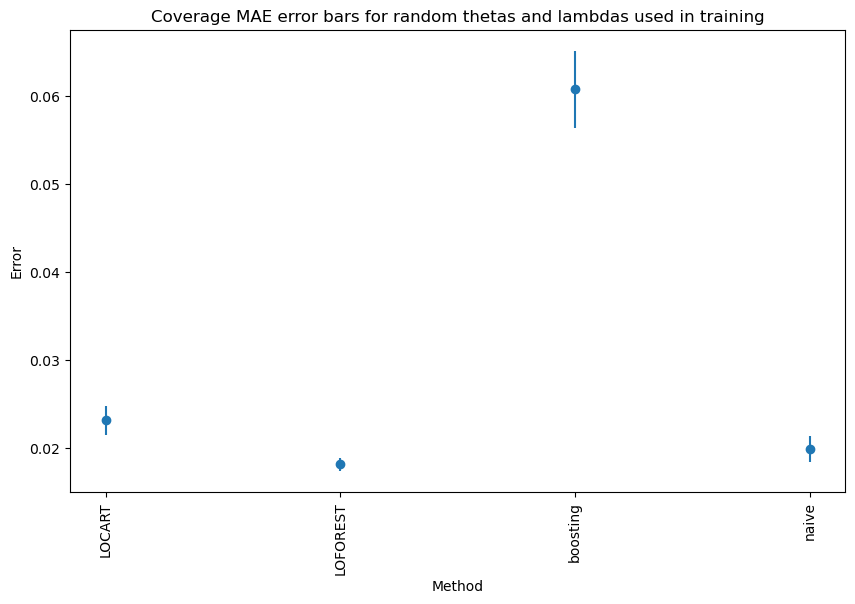

In [11]:
#| echo: false
keys = cover_data[0].iloc[:, 0].values
mae = cover_data[0].iloc[:, 1].values
std_err = cover_data[0].iloc[:, 2].values

plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

Visualizing coverage as a function of $x$:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


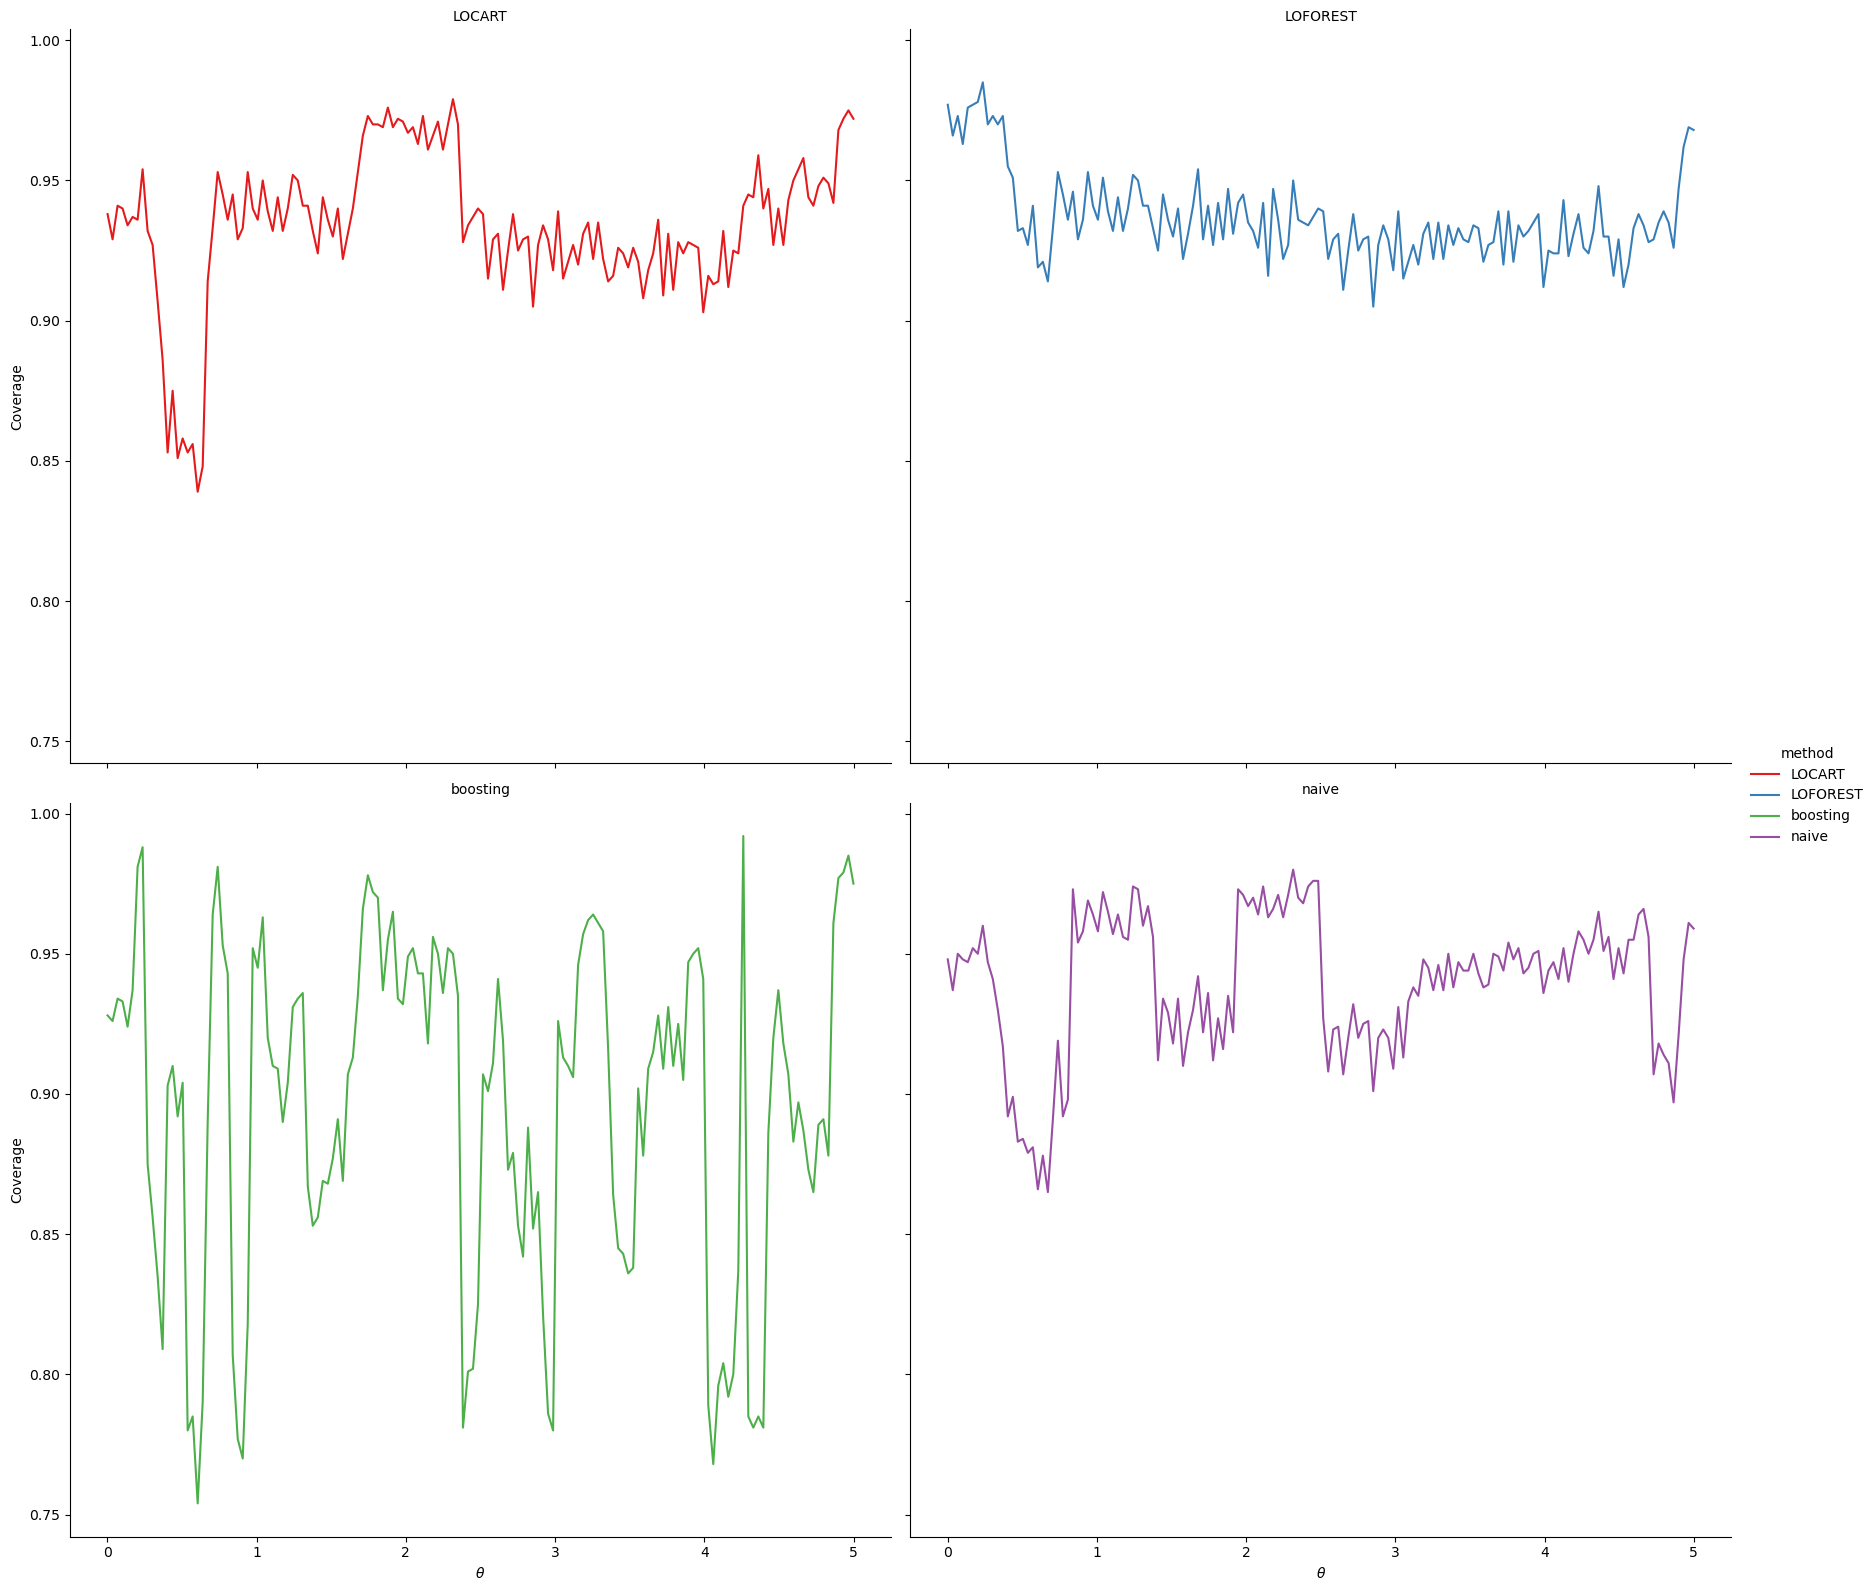

In [12]:
#| echo: false
# Melt the coverage data
coverage_data_melted = pd.melt(
    cover_data[1], id_vars=["thetas"], var_name="method", value_name="coverage")
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(coverage_data_melted, col="method", hue = "method",
 col_wrap = 2, height=8, aspect=1.10, palette = "Set1")
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.show()

Now, we compute the coverage and MAE's for each method across three sample sizes $N$, through the following functions:

In [14]:
# function to compute all quantiles in a theta grid
def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators=200,
    K=40,
    naive_n=500,
):
    # fitting and predicting naive
    naive_quantiles = naive(alpha=alpha, B=B, N=N, naive_n=naive_n, rng=rng)
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # simulating to fit models
    theta_sim, model_lambdas = sample_gmm(n=B, N=N, rng=rng)
    model_thetas = theta_sim.reshape(-1, 1)

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas,
        model_lambdas,
        min_samples_leaf=100,
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas,
        model_lambdas,
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        K=K,
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # naive quantiles
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # locart quantiles
    idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

    # boosting
    boosting_quantiles = model.predict(thetas.reshape(-1, 1))

    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest": loforest_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict


# evaluate coverage for several N's and B = 1000
def evaluate_coverage_N(
    thetas,
    N=np.array([10, 100, 1000]),
    B=1000,
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    n_estimators=200,
    K=40,
    naive_n=100,
):
    coverage_data = np.zeros((thetas.shape[0] * N.shape[0], 4))
    N_list = []
    N_list_cover = []
    methods_list = []
    rng = np.random.default_rng(seed)
    k = 0
    j = 0
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        # computing all quantiles for fixed N
        quantiles_dict = obtain_quantiles(
            thetas,
            N=N_fixed,
            B=B,
            alpha=alpha,
            min_samples_leaf=min_samples_leaf,
            naive_n=naive_n,
            rng=rng,
            n_estimators=n_estimators,
            K=K,
        )
        err_data = np.zeros((thetas.shape[0], 4))
        l = 0
        for theta in tqdm(thetas, desc="Computing coverage for each method"):
            # generating several lambdas
            LRT_stat = np.zeros(n)
            for i in range(0, n):
                samples = sim_gmm(N_fixed, theta, rng=rng)
                LRT_stat[i] = compute_lrt_statistic(theta, samples)

            # comparing coverage of methods
            locart_cover = np.mean(LRT_stat <= quantiles_dict["locart"][l])
            loforest_cover = np.mean(LRT_stat <= quantiles_dict["loforest"][l])
            boosting_cover = np.mean(LRT_stat <= quantiles_dict["boosting"][l])
            naive_cover = np.mean(LRT_stat <= quantiles_dict["naive"][l])

            # appending the errors
            err_locart = np.abs(locart_cover - (1 - alpha))
            err_loforest = np.abs(loforest_cover - (1 - alpha))
            err_boosting = np.abs(boosting_cover - (1 - alpha))
            err_naive = np.abs(naive_cover - (1 - alpha))

            # saving in numpy array
            err_data[l, :] = np.array(
                [err_locart, err_loforest, err_boosting, err_naive]
            )

            coverage_data[j, :] = np.array(
                [locart_cover, loforest_cover, boosting_cover, naive_cover]
            )
            N_list_cover.append(N_fixed)

            j += 1
            l += 1
        methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
        if k == 0:
            mae_vector = np.mean(err_data, axis=0)
            std_vector = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
        else:
            mean = np.mean(err_data, axis=0)
            std = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
            mae_vector, std_vector = np.concatenate((mae_vector, mean)), np.concatenate(
                (std_vector, std)
            )
        k += 1
        N_list.extend([N_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "MAE": mae_vector,
            "se": std_vector,
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": np.tile(thetas, N.shape[0]),
            "N": N_list_cover,
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

Computing coverage fixing $B = 1000$:

In [15]:
#| output: false
n_out = 150
thetas = np.linspace(0.001, 4.999, n_out)

coverage_data_N_1000 = evaluate_coverage_N(
    thetas, 
    B = 1000, 
    naive_n = 100, 
    n = 1000,
    seed = 1250,
    n_estimators = 200,
    K = 40,
    )

Computing coverage for each N:   0%|          | 0/3 [00:00<?, ?it/s]/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
Computing coverage for each N:  33%|███▎      | 1/3 [03:28<06:57, 208.72s/it]/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
Computing coverage for each N:  67%|██████▋   | 2/3 [07:05<03:3

Plotting MAE and standard error for each method and several $N$:

/tmp/ipykernel_61502/2511381227.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=90)


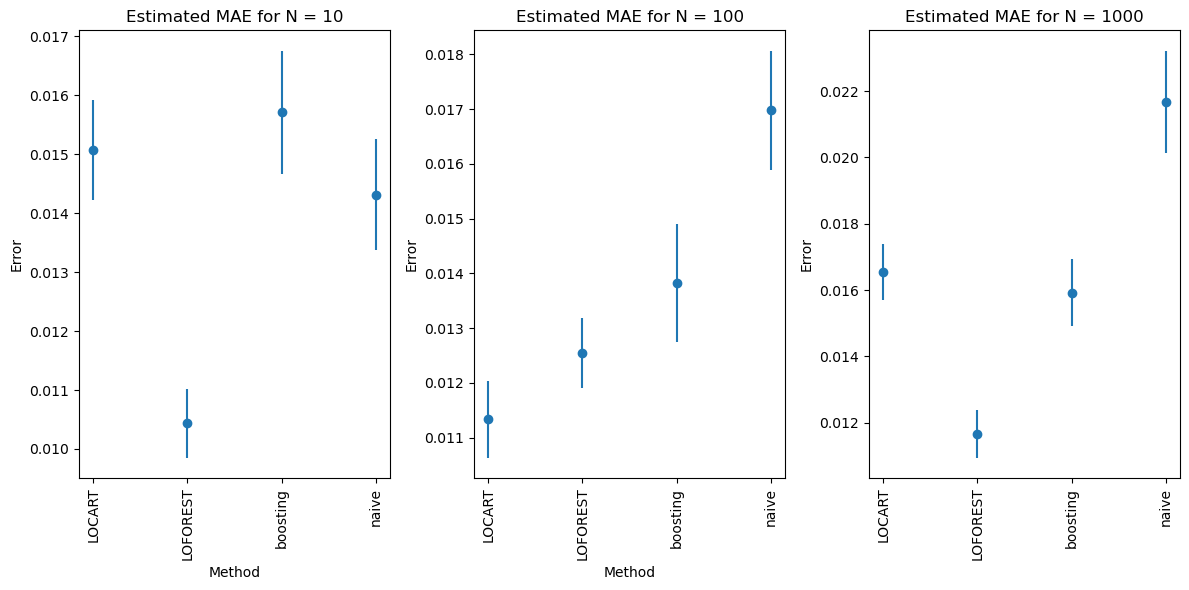

In [16]:
# | echo: false
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
# data for first subplot
data_10 = coverage_data_N_1000[0].query("N == 10")
keys = data_10.iloc[:, 0].values
mae = data_10.iloc[:, 2].values
std_err = data_10.iloc[:, 3].values
ax[0].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[0].set_xlabel("Method")
ax[0].set_ylabel("Error")
ax[0].set_title("Estimated MAE for N = 10")


data_100 = coverage_data_N_1000[0].query("N == 100")
keys = data_100.iloc[:, 0].values
mae = data_100.iloc[:, 2].values
std_err = data_100.iloc[:, 3].values
ax[1].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[1].set_xlabel("Method")
ax[1].set_ylabel("Error")
ax[1].set_title("Estimated MAE for N = 100")


data_1000 = coverage_data_N_1000[0].query("N == 1000")
keys = data_1000.iloc[:, 0].values
mae = data_1000.iloc[:, 2].values
std_err = data_1000.iloc[:, 3].values
ax[2].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[2].set_ylabel("Error")
ax[2].set_title("Estimated MAE for N = 1000")

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Plotting the coverage line of all methods:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_61502/556147679.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


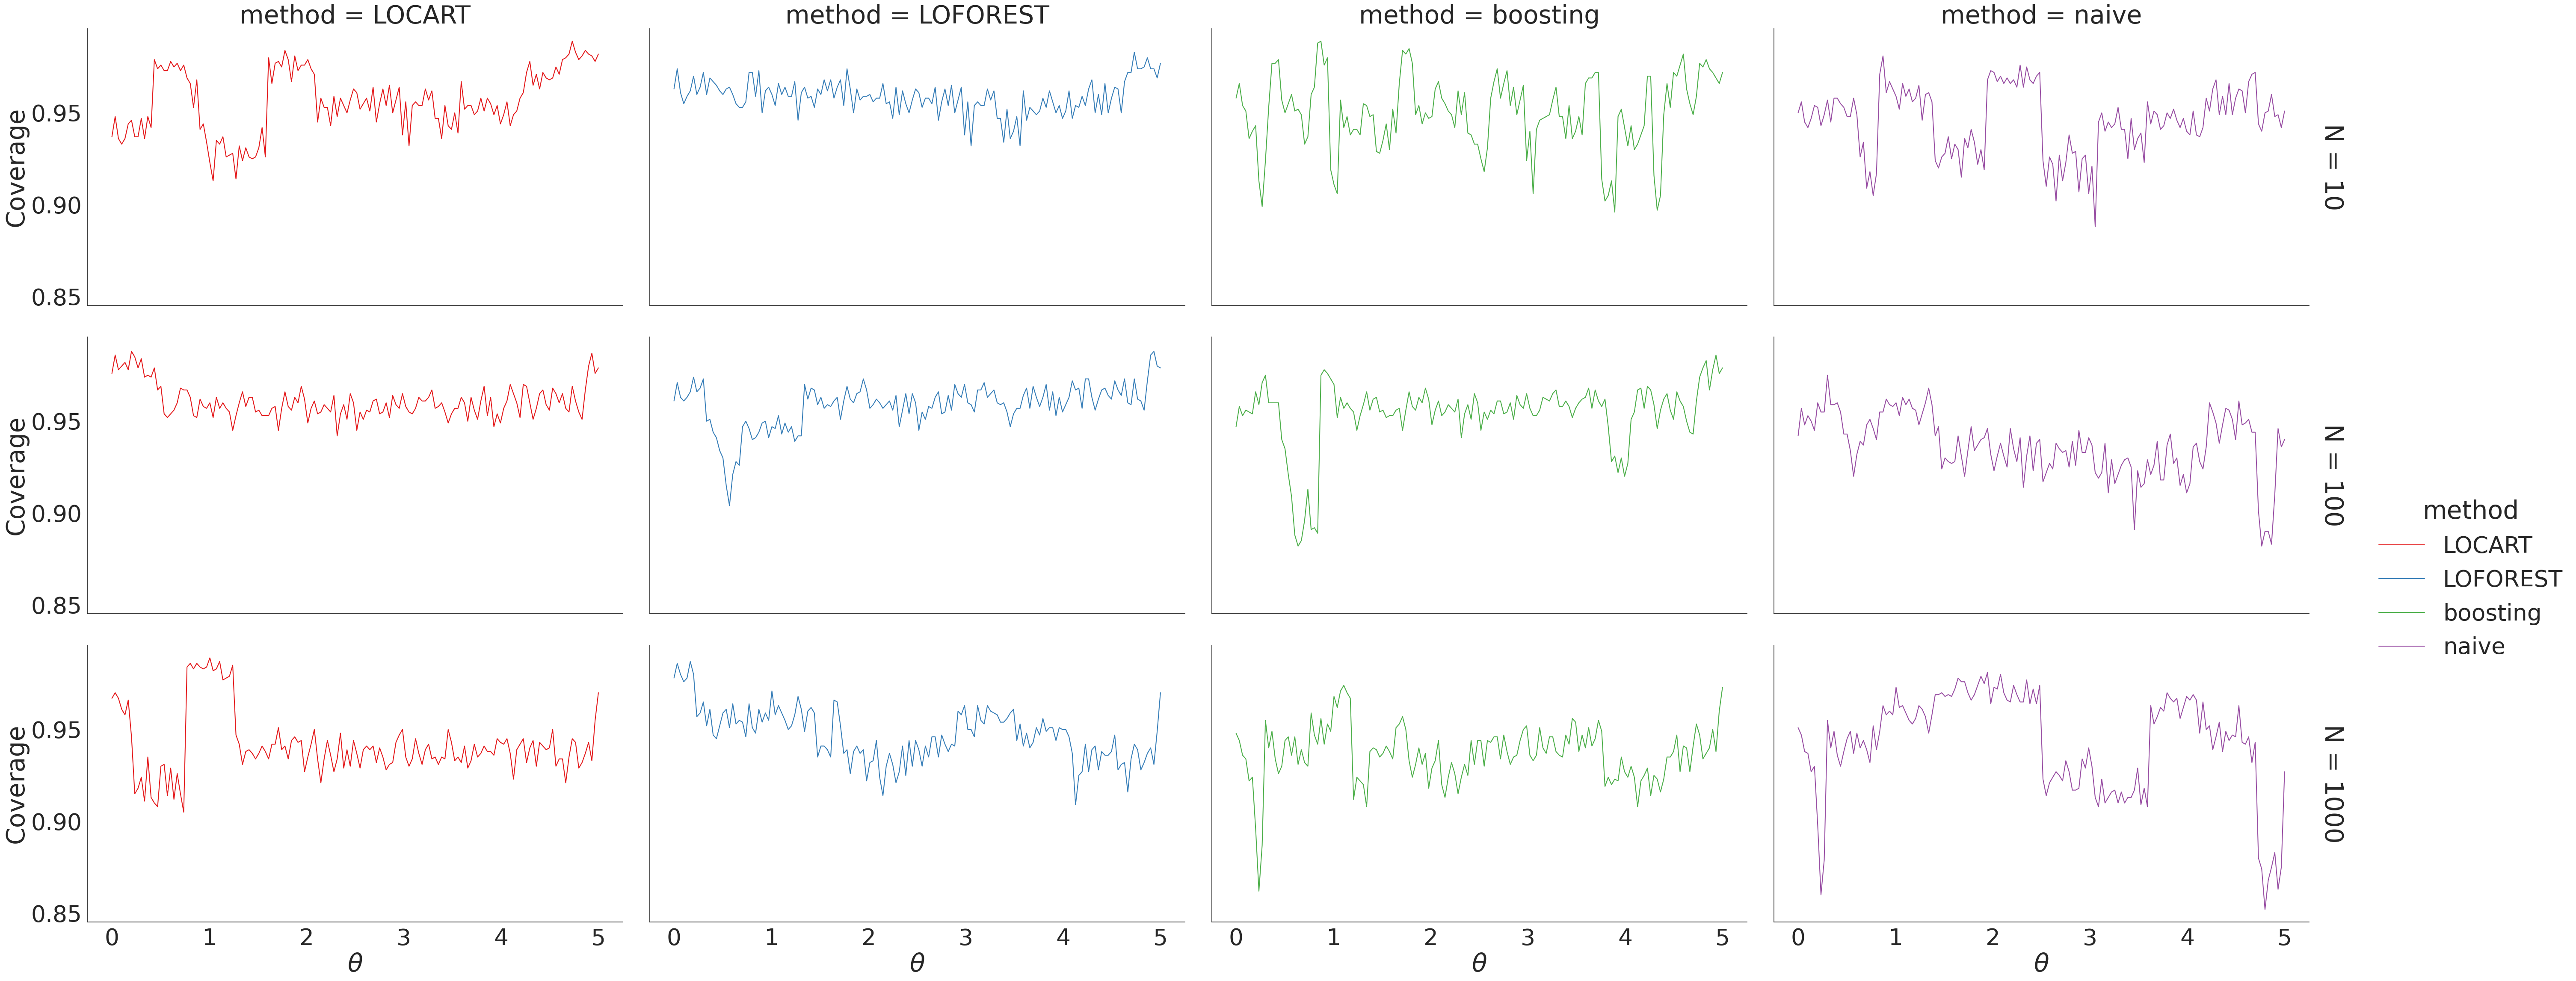

In [17]:
# | echo: false
# plotting coverage
coverage_data_melted = pd.melt(
    coverage_data_N_1000[1],
    id_vars=["thetas", "N"],
    var_name="method",
    value_name="coverage",
)
# Plot the coverage as function of the thetas generated
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    coverage_data_melted,
    row="N",
    col="method",
    hue="method",
    height=8,
    aspect=1.60,
    palette="Set1",
    margin_titles=True,
)
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend(bbox_to_anchor=(1., 0.5), loc=2, borderaxespad=0.)
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.tight_layout()
plt.show()

Increasing $B$ to 5000 samples and testing:

In [18]:
# | output: false
coverage_data_N_5000 = evaluate_coverage_N(
    thetas,
    B=5000,
    naive_n=100,
    min_samples_leaf=250,
    n=1000,
    seed=45,
    n_estimators = 200,
    K = 40,
)

Computing coverage for each N:   0%|          | 0/3 [00:00<?, ?it/s]/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
Computing coverage for each N:  33%|███▎      | 1/3 [03:04<06:08, 184.18s/it]/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
Computing coverage for each N:  67%|██████▋   | 2/3 [06:10<03:0

Plotting all results again:

/tmp/ipykernel_61502/168848921.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=90)


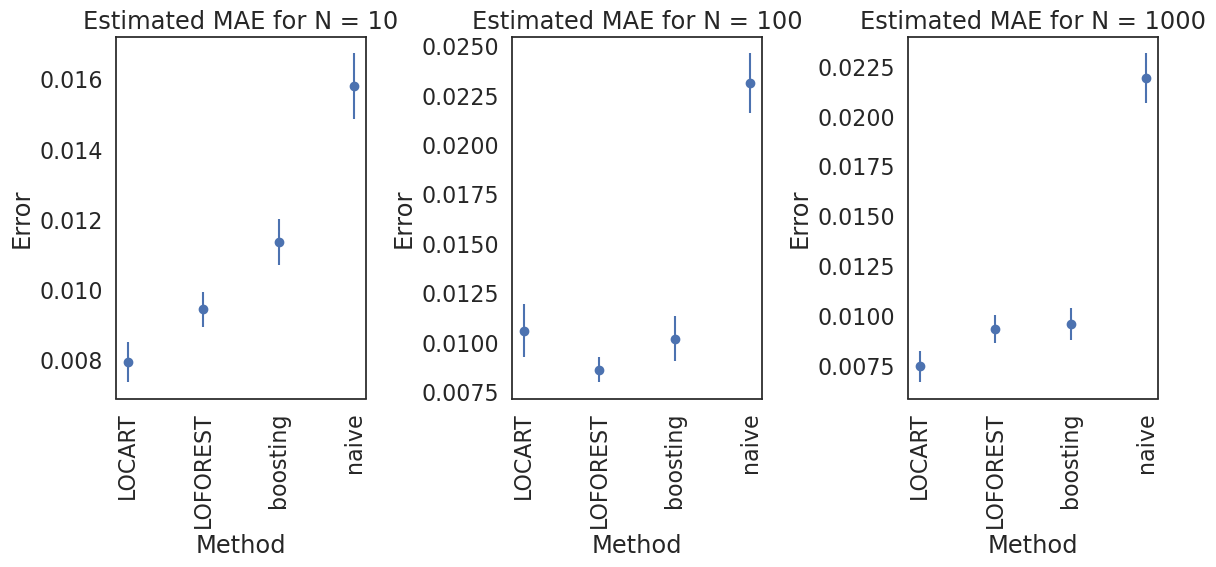

In [19]:
#| echo: false
sns.set(style="white", font_scale=1.45)
fig, ax = plt.subplots(ncols = 3, figsize=(12, 6))
# data for first subplot
data_10 = coverage_data_N_5000[0].query('N == 10')
keys = data_10.iloc[:, 0].values
mae = data_10.iloc[:, 2].values
std_err = data_10.iloc[:, 3].values
ax[0].errorbar(keys, mae, yerr = std_err, fmt = 'o')
ax[0].set_xlabel('Method')
ax[0].set_ylabel('Error')
ax[0].set_title('Estimated MAE for N = 10')


data_100 = coverage_data_N_5000[0].query('N == 100')
keys = data_100.iloc[:, 0].values
mae = data_100.iloc[:, 2].values
std_err = data_100.iloc[:, 3].values
ax[1].errorbar(keys, mae, yerr = std_err, fmt = 'o')
ax[1].set_xlabel('Method')
ax[1].set_ylabel('Error')
ax[1].set_title('Estimated MAE for N = 100')


data_1000 = coverage_data_N_5000[0].query('N == 1000')
keys = data_1000.iloc[:, 0].values
mae = data_1000.iloc[:, 2].values
std_err = data_1000.iloc[:, 3].values
ax[2].errorbar(keys, mae, yerr = std_err, fmt = 'o')
ax[2].set_xlabel('Method')
ax[2].set_ylabel('Error')
ax[2].set_title('Estimated MAE for N = 1000')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_61502/2052937120.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


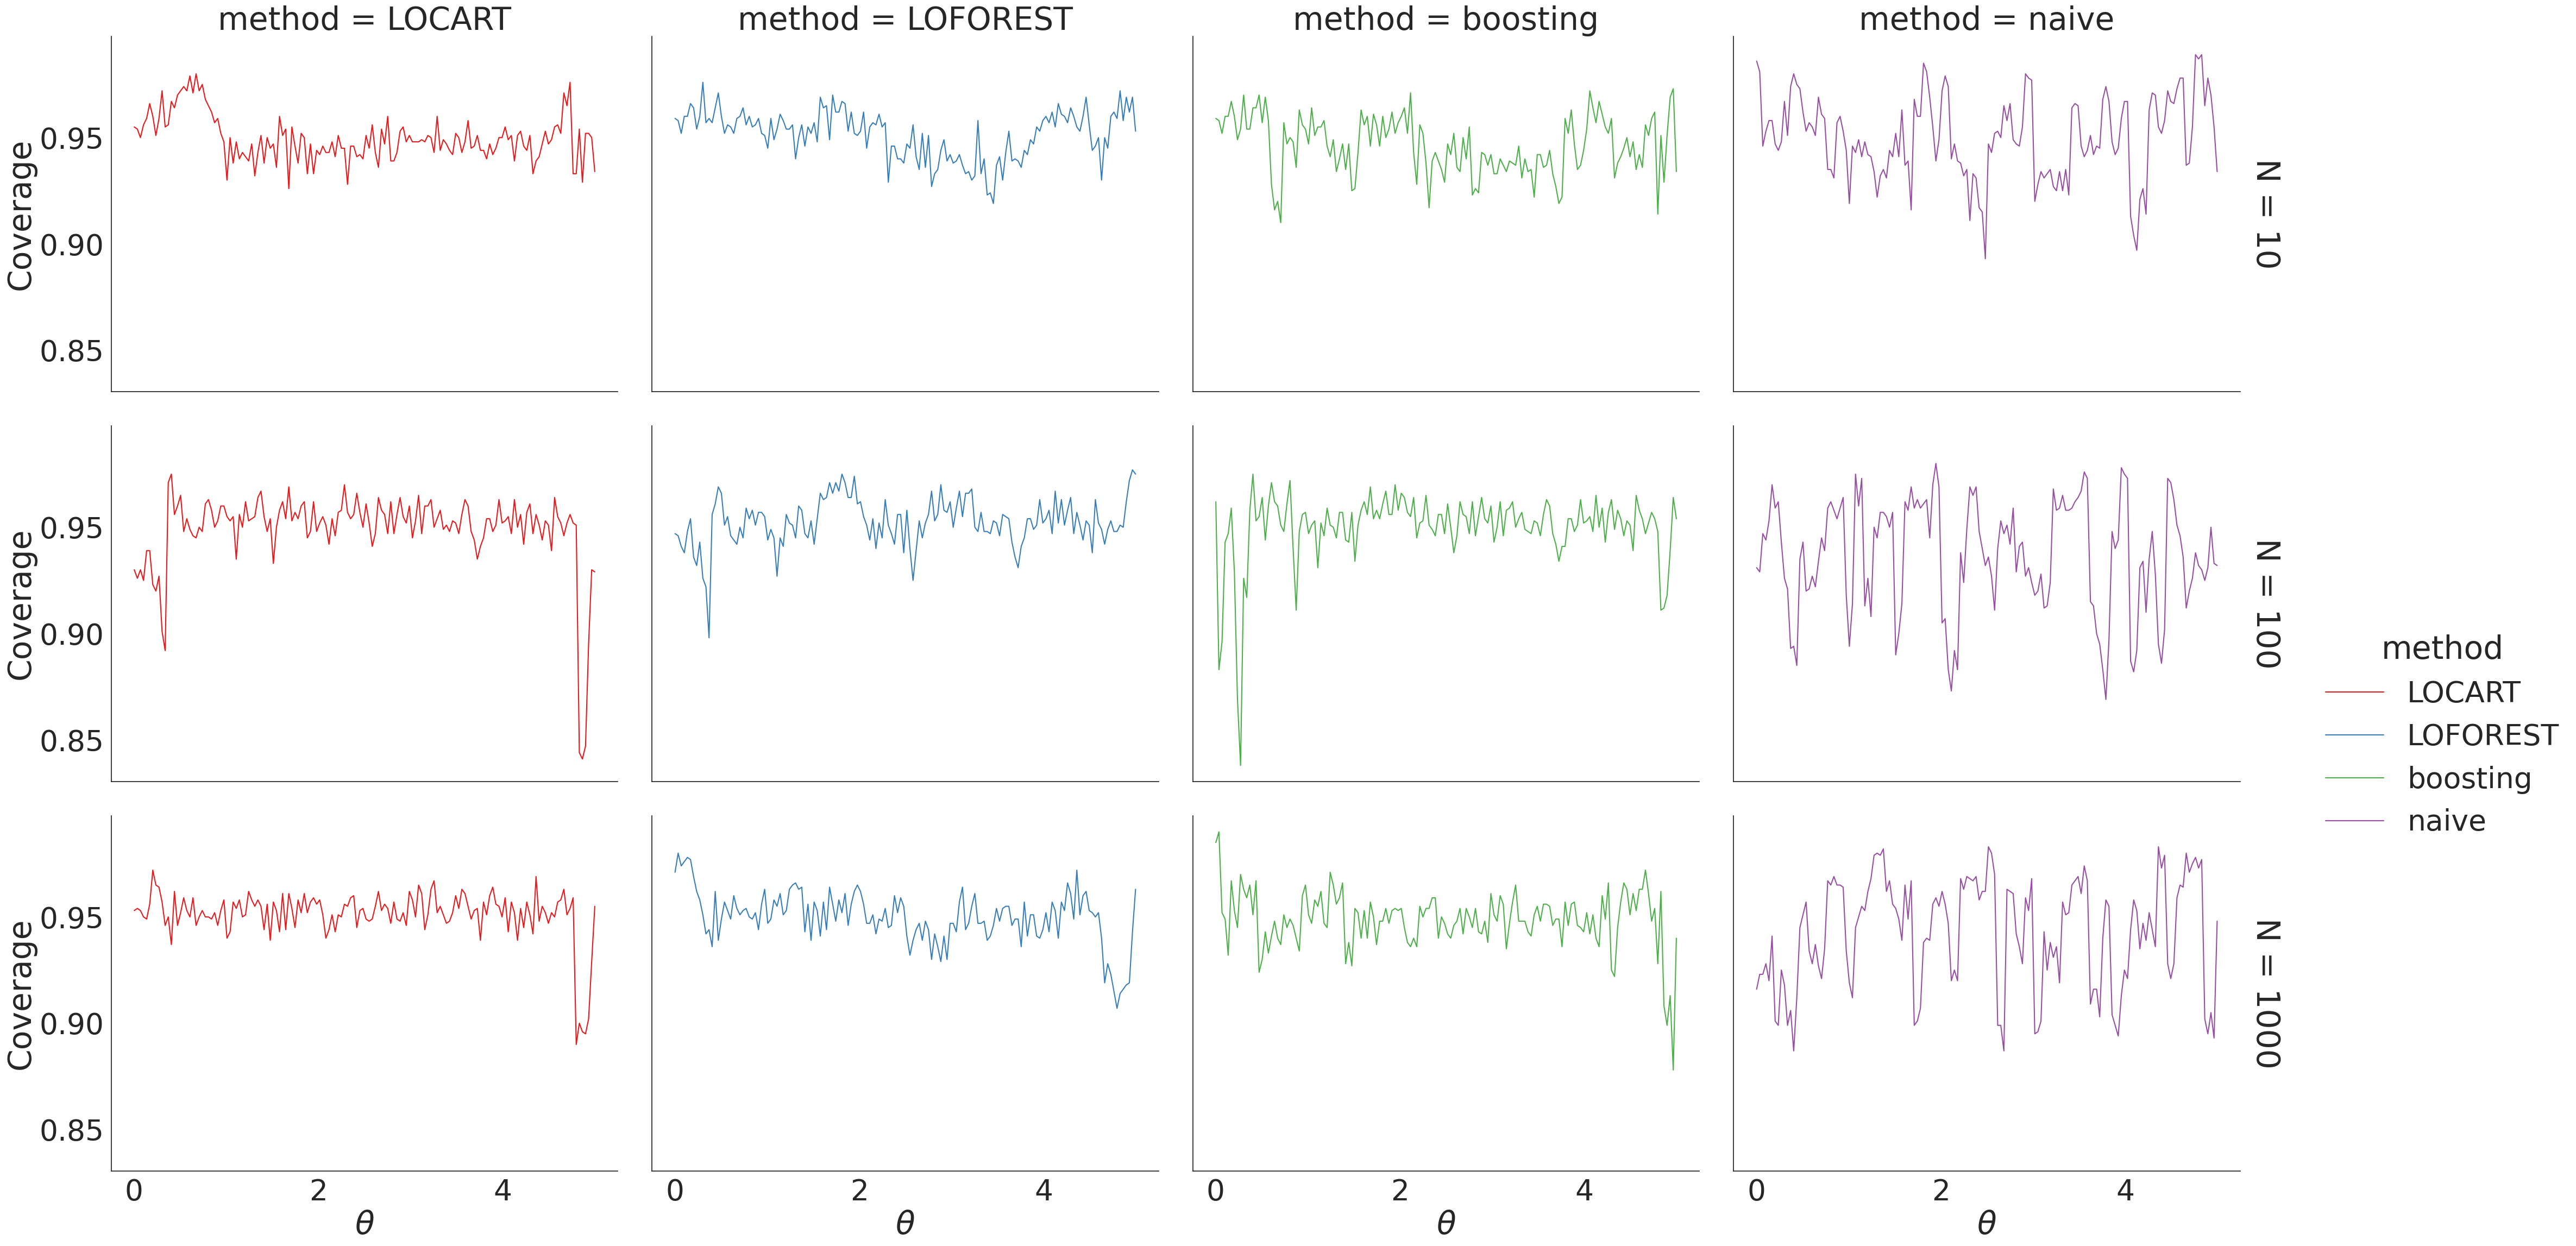

In [20]:
#| echo: false
# plotting coverage
coverage_data_melted = pd.melt(
    coverage_data_N_5000[1],
    id_vars=["thetas", "N"],
    var_name="method",
    value_name="coverage",
)
# Plot the coverage as function of the thetas generated
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    coverage_data_melted,
    row="N",
    col="method",
    hue="method",
    height= 8,
    aspect=1.20,
    palette="Set1",
    margin_titles=True,
)
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend(bbox_to_anchor=(1., 0.5), loc=2, borderaxespad=0.)
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.tight_layout()
plt.show()

As the naive method performed very well in all cases, lets check if the distribution of $\lambda$ is invariant across $\theta$ through:

/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


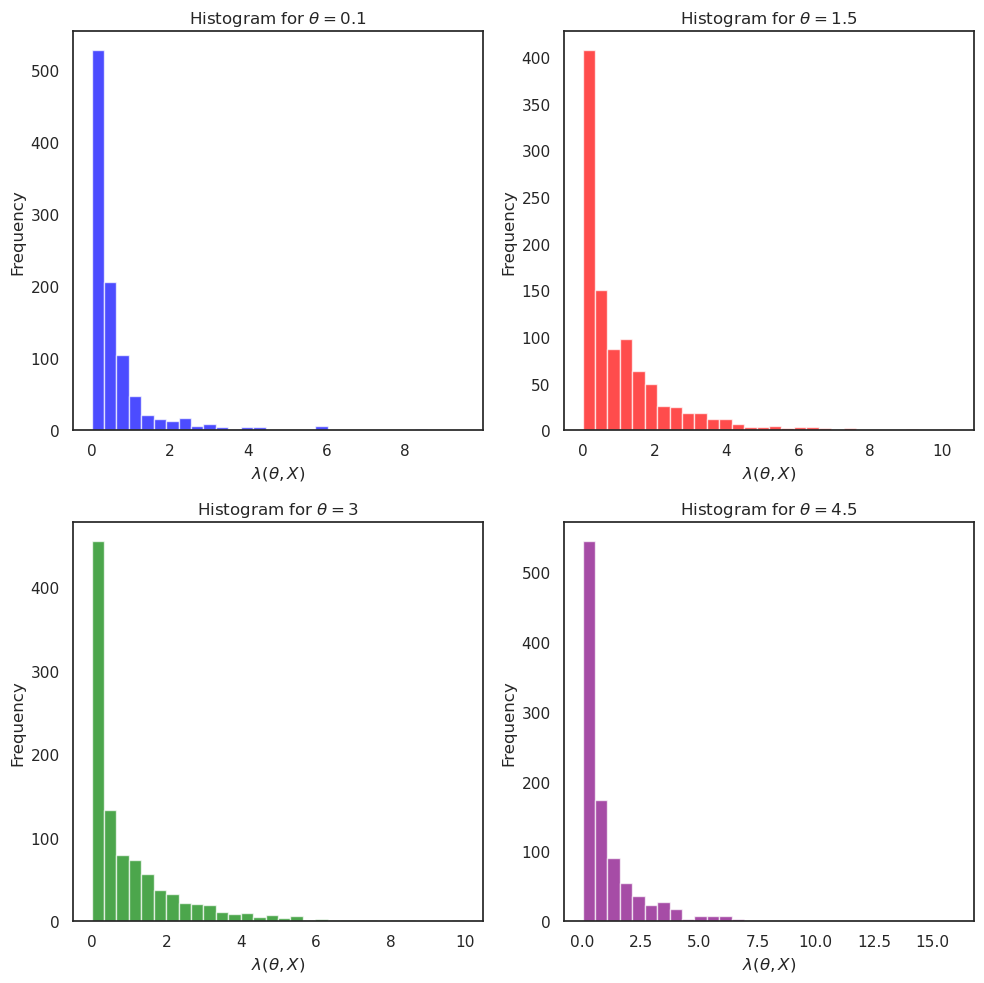

In [23]:
# | echo: false
# simulating and comparing four samples
rng = np.random.default_rng(145)
lambdas_1, lambdas_2, lambdas_3, lambdas_4 = (
    np.zeros(1000),
    np.zeros(1000),
    np.zeros(1000),
    np.zeros(1000),
)

for i in range(0, 1000):
    X = sim_gmm(B=1000, theta=0.1, rng=rng)
    lambdas_1[i] = compute_lrt_statistic(0.1, X)

    X = sim_gmm(B=1000, theta=1.5, rng=rng)
    lambdas_2[i] = compute_lrt_statistic(1.5, X)

    X = sim_gmm(B=1000, theta=3, rng=rng)
    lambdas_3[i] = compute_lrt_statistic(3, X)

    X = sim_gmm(B=1000, theta=4.5, rng=rng)
    lambdas_4[i] = compute_lrt_statistic(4.5, X)

sns.set(style="white", font_scale=1)
# plotting histograms
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].hist(lambdas_1, bins=30, color="blue", alpha=0.7)
axs[0, 0].set_title(r"Histogram for $\theta = 0.1$")
axs[0, 0].set_xlabel(r"$\lambda(\theta, X)$")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].hist(lambdas_2, bins=30, color="red", alpha=0.7)
axs[0, 1].set_title(r"Histogram for $\theta = 1.5$")
axs[0, 1].set_xlabel(r"$\lambda(\theta, X)$")
axs[0, 1].set_ylabel("Frequency")

axs[1, 0].hist(lambdas_3, bins=30, color="green", alpha=0.7)
axs[1, 0].set_title(r"Histogram for $\theta = 3$")
axs[1, 0].set_xlabel(r"$\lambda(\theta, X)$")
axs[1, 0].set_ylabel("Frequency")

axs[1, 1].hist(lambdas_4, bins=30, color="purple", alpha=0.7)
axs[1, 1].set_title(r"Histogram for $\theta = 4.5$")
axs[1, 1].set_xlabel(r"$\lambda(\theta, X)$")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Despite the statistic being invariant, lets analyze how each method behaves as a function of $B$ for $N \in \{1, 50, 100, 1000\}$:


In [24]:
def compute_MAE_N(
    thetas,
    N=np.array([1, 10, 100, 1000]),
    B=np.array([500, 1000, 5000, 10000, 15000, 20000]),
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    n_estimators=100,
    K=50,
    naive_n=100,
):
    N_list = []
    mae_list = []
    se_list = []
    methods_list = []
    B_list = []
    j = 0
    rng = np.random.default_rng(seed)
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        k = 0
        for B_fixed in B:
            # computing all quantiles for fixed N
            quantiles_dict = obtain_quantiles(
                thetas,
                N=N_fixed,
                B=B_fixed,
                alpha=alpha,
                min_samples_leaf=min_samples_leaf,
                naive_n=naive_n,
                n_estimators=n_estimators,
                K=K,
                rng=rng,
            )
            err_data = np.zeros((thetas.shape[0], 4))
            l = 0
            for theta in thetas:
                # generating several lambdas
                lambda_stat = sim_lambda(
                    B=n,
                    N=N_fixed,
                    theta=theta,
                    rng=rng,
                )

                # comparing coverage of methods
                locart_cover = np.mean(lambda_stat <= quantiles_dict["locart"][l])
                loforest_cover = np.mean(lambda_stat <= quantiles_dict["loforest"][l])
                boosting_cover = np.mean(lambda_stat <= quantiles_dict["boosting"][l])
                naive_cover = np.mean(lambda_stat <= quantiles_dict["naive"][l])

                # appending the errors
                err_locart = np.abs(locart_cover - (1 - alpha))
                err_loforest = np.abs(loforest_cover - (1 - alpha))
                err_boosting = np.abs(boosting_cover - (1 - alpha))
                err_naive = np.abs(naive_cover - (1 - alpha))

                # saving in numpy array
                err_data[l, :] = np.array(
                    [err_locart, err_loforest, err_boosting, err_naive]
                )

                l += 1

            mae_list.extend(np.mean(err_data, axis = 0).tolist())
            se_list.extend((np.std(err_data, axis = 0)/np.sqrt(thetas.shape[0])).tolist())
            methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
            N_list.extend([N_fixed] * 4)
            B_list.extend([B_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [25]:
# | output: false
n_out = 150
thetas = np.linspace(0.001, 4.999, n_out)

mae_stats = compute_MAE_N(
    thetas,
    N=np.array([1, 50, 100, 1000]),
    naive_n=500,
    min_samples_leaf=300,
    n_estimators = 200,
    K = 50,
    seed=1250,
)

Computing coverage for each N:   0%|          | 0/4 [00:00<?, ?it/s]/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support rela

Plotting all results:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

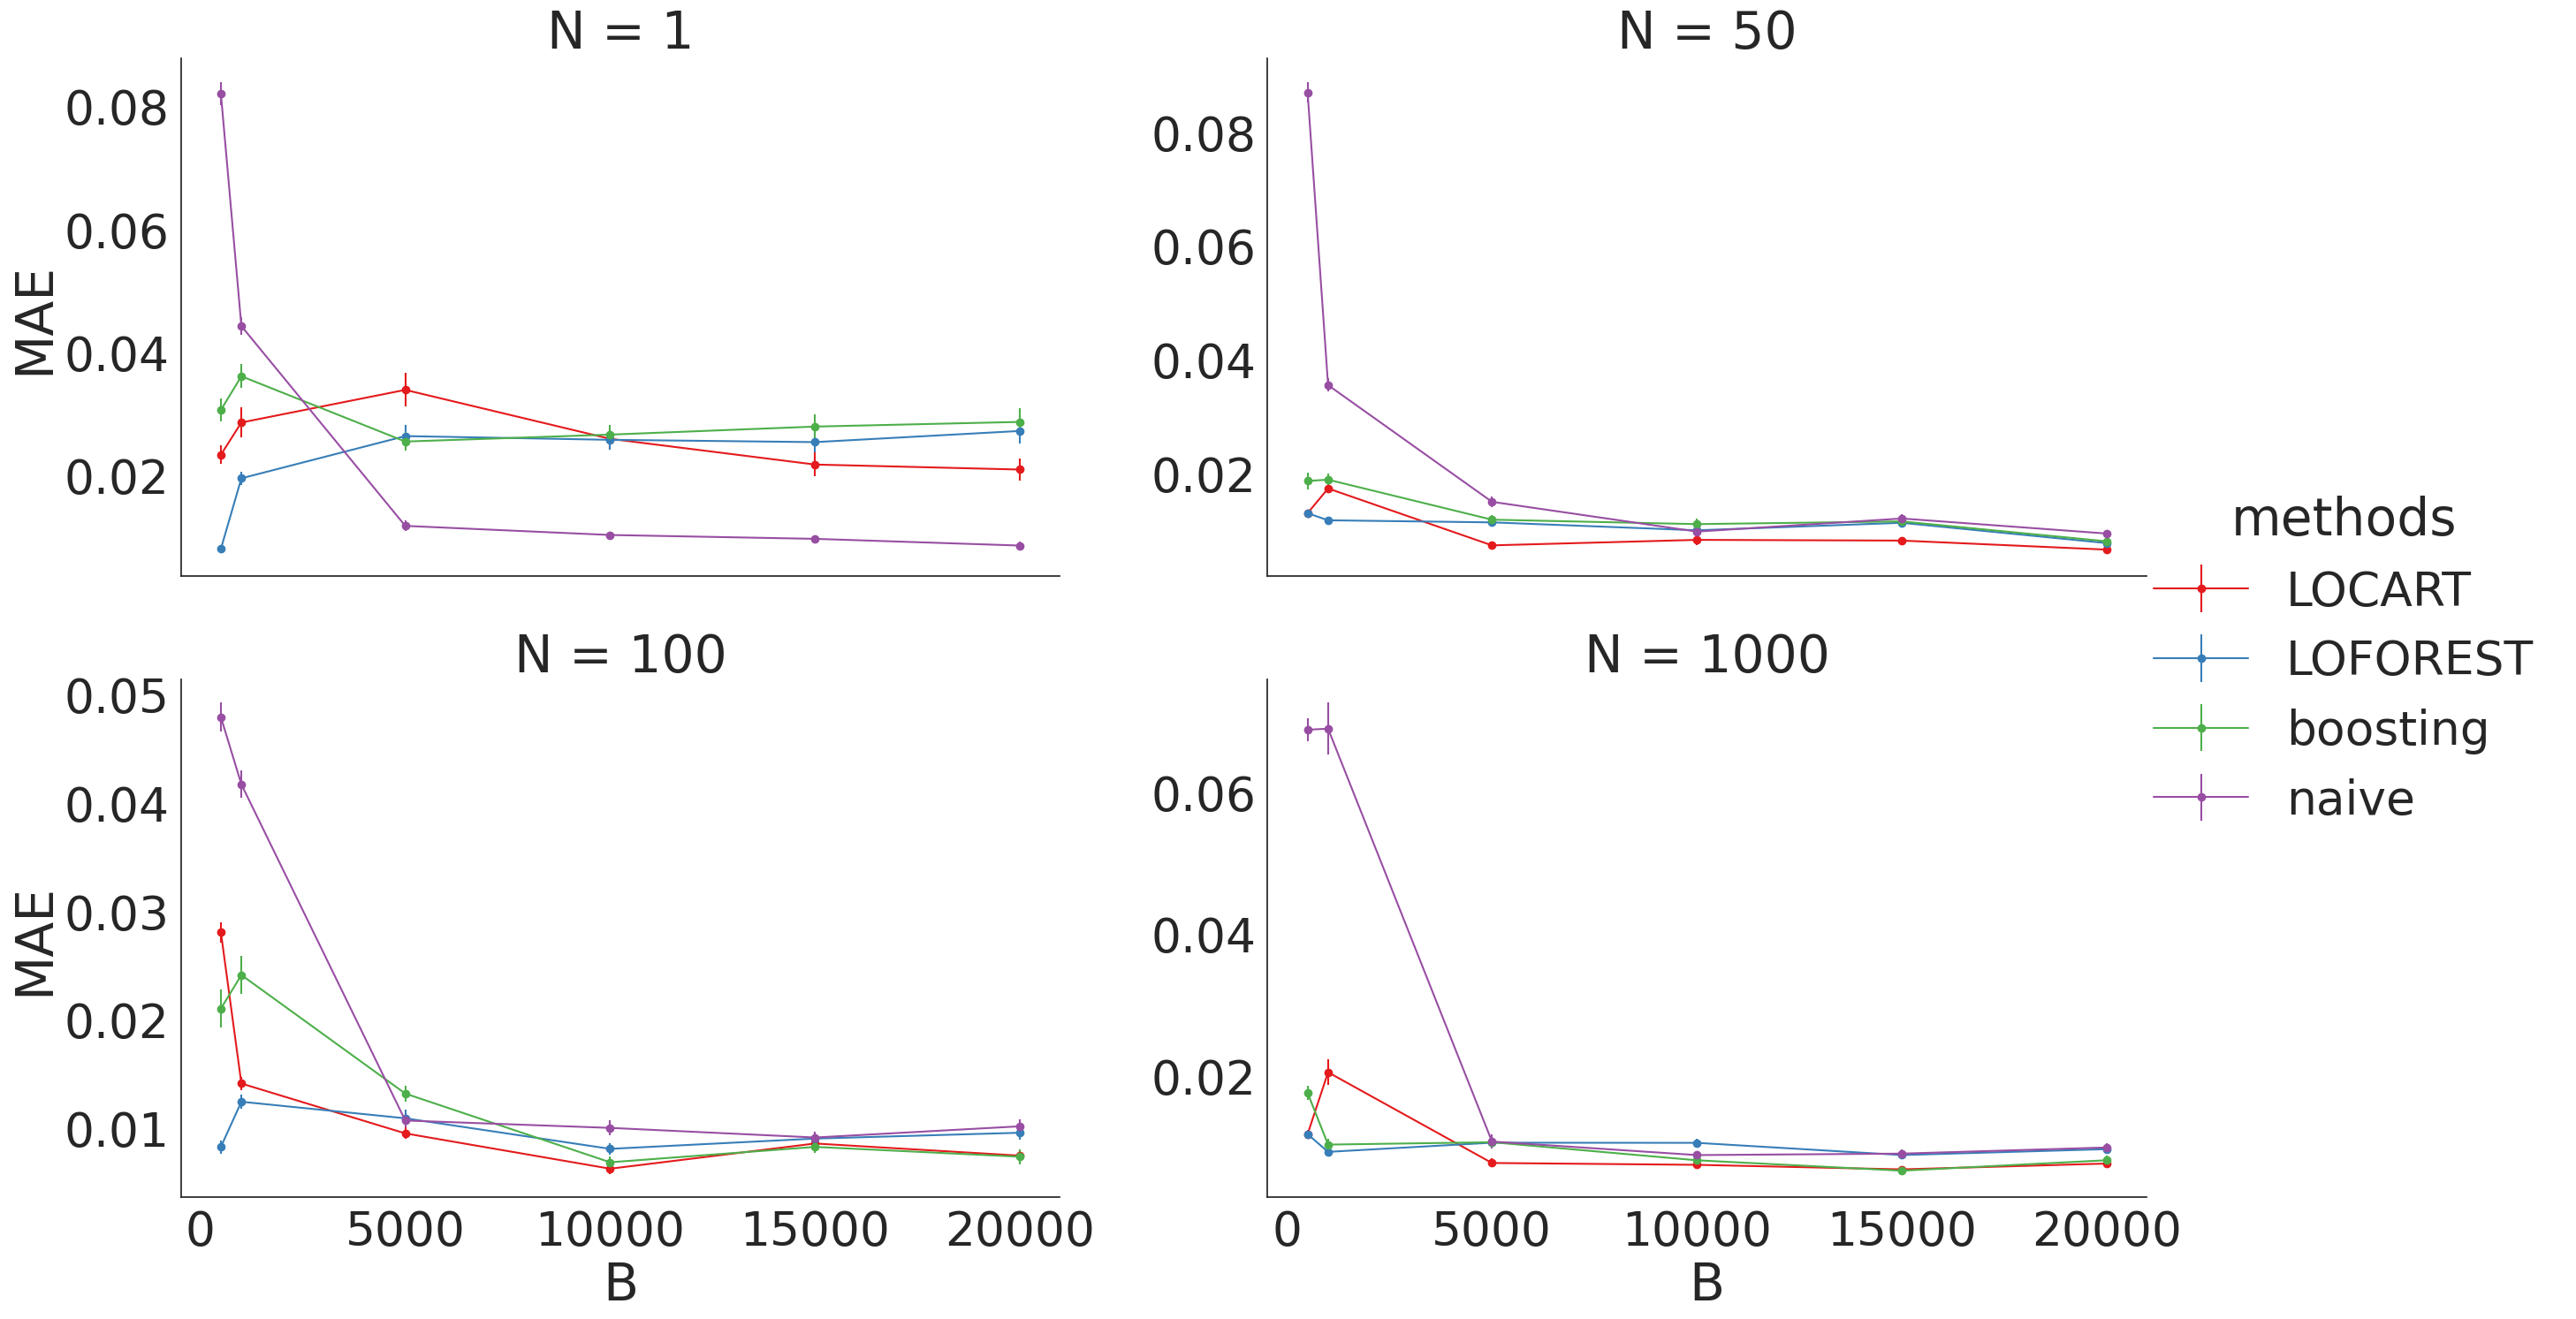

In [26]:
# | echo: false
# Create a line plot with error bars
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()